COVID 19 impact forecast across India

Importing libraries

In [1]:
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Importing dataset

In [2]:
data1 = pd.read_csv("https://data.covid19india.org/csv/latest/districts.csv")
data1 = data1.drop(['Other','Tested'],axis=1)
data1

,Date,State,District,Confirmed,Recovered,Deceased
0,2020-04-26,Andaman and Nicobar Islands,Unknown,33,11,0
1,2020-04-26,Andhra Pradesh,Anantapur,53,14,4
2,2020-04-26,Andhra Pradesh,Chittoor,73,13,0
3,2020-04-26,Andhra Pradesh,East Godavari,39,12,0
4,2020-04-26,Andhra Pradesh,Guntur,214,29,8
...,...,...,...,...,...,...
358628,2021-10-31,West Bengal,Purba Bardhaman,42005,41588,198
358629,2021-10-31,West Bengal,Purba Medinipur,63098,62549,397
358630,2021-10-31,West Bengal,Purulia,19419,19283,113
358631,2021-10-31,West Bengal,South 24 Parganas,100957,98950,1336


Sorting data datewise and by each district of each state

In [3]:
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values(by=['State','District','Date'],inplace=False)
data1

,Date,State,District,Confirmed,Recovered,Deceased
0,2020-04-26,Andaman and Nicobar Islands,Unknown,33,11,0
408,2020-04-27,Andaman and Nicobar Islands,Unknown,33,11,0
828,2020-04-28,Andaman and Nicobar Islands,Unknown,33,15,0
1256,2020-04-29,Andaman and Nicobar Islands,Unknown,33,15,0
1689,2020-04-30,Andaman and Nicobar Islands,Unknown,33,16,0
...,...,...,...,...,...,...
355995,2021-10-27,West Bengal,Uttar Dinajpur,19829,19532,236
356655,2021-10-28,West Bengal,Uttar Dinajpur,19841,19538,237
357314,2021-10-29,West Bengal,Uttar Dinajpur,19847,19545,238
357973,2021-10-30,West Bengal,Uttar Dinajpur,19850,19552,238


Time series data grouped by date for whole of India

In [4]:
data2 = data1.groupby(['Date'],as_index=False).sum()
data2

,Date,Confirmed,Recovered,Deceased
0,2020-04-26,27890,6523,881
1,2020-04-27,29458,7103,939
2,2020-04-28,31360,7739,1008
3,2020-04-29,33065,8429,1079
4,2020-04-30,34867,9059,1154
...,...,...,...,...
549,2021-10-27,34231243,33606777,456418
550,2021-10-28,34245550,33619966,457223
551,2021-10-29,34259765,33633515,457774
552,2021-10-30,34272705,33648187,458219


Finding maximum value of confirmed cases to assess the risk

In [5]:
maximum = data2["Confirmed"].max()
maximum

34285612

In [6]:
data2[data2["Confirmed"] == data2["Confirmed"].max()]

,Date,Confirmed,Recovered,Deceased
553,2021-10-31,34285612,33661339,458470


Plotting the data

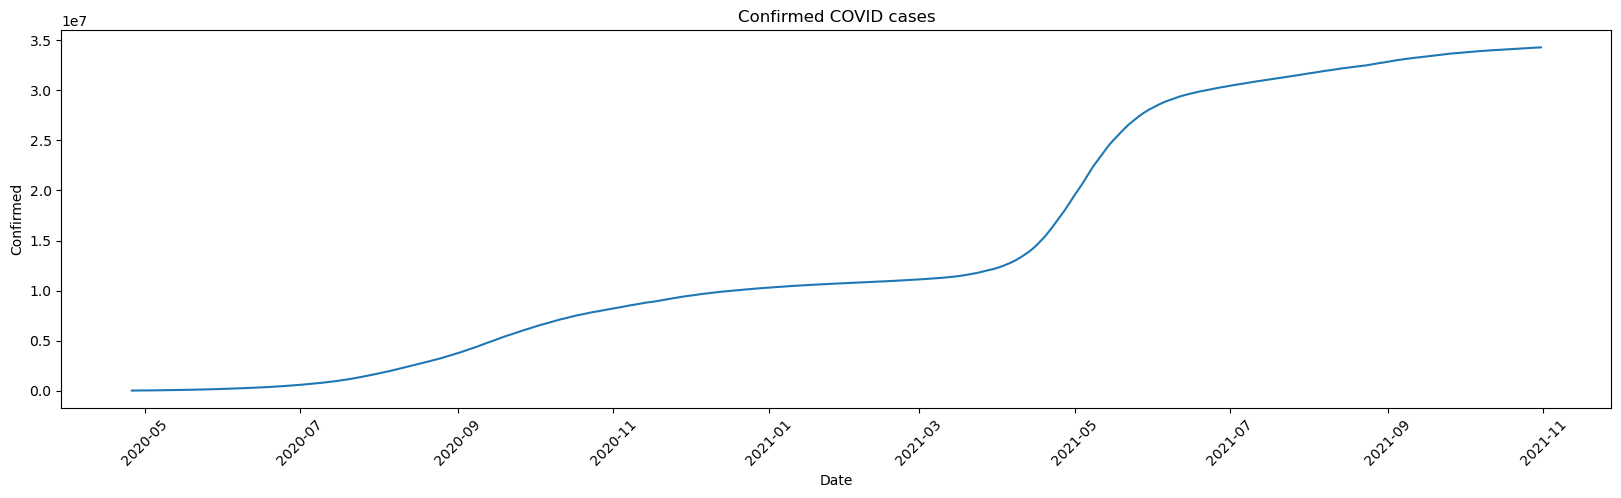

In [7]:
fig = plt.figure(figsize=(20,5),dpi=100)
plt.title("Confirmed COVID cases")
sns.lineplot(data=data2, x= 'Date', y = 'Confirmed')
plt.xticks(rotation=45,fontsize=10);

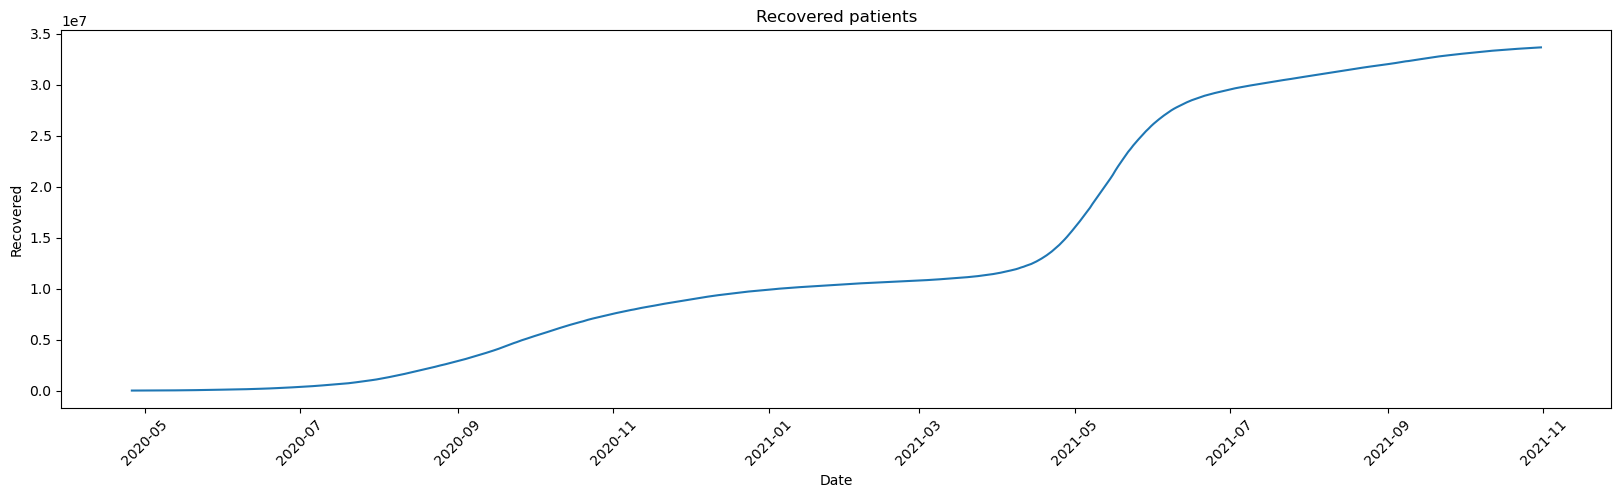

In [8]:
fig = plt.figure(figsize=(20,5),dpi=100)
plt.title("Recovered patients")
sns.lineplot(data=data2, x= 'Date', y = 'Recovered')
plt.xticks(rotation=45,fontsize=10);

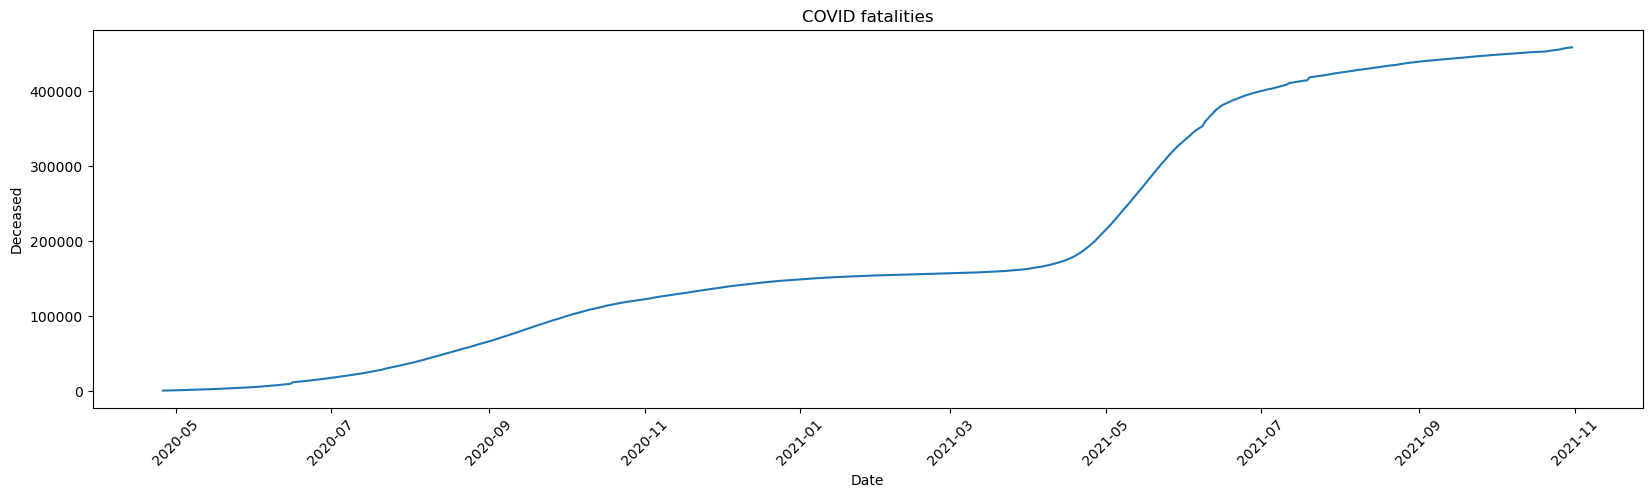

In [9]:
fig = plt.figure(figsize=(20,5),dpi=100)
plt.title("COVID fatalities")
sns.lineplot(data=data2, x= 'Date', y = 'Deceased')
plt.xticks(rotation=45,fontsize=10);

Getting only confirmed cases datewise (This is what we are interested in)

In [10]:
data3 = data2[['Date','Confirmed']]
data3

,Date,Confirmed
0,2020-04-26,27890
1,2020-04-27,29458
2,2020-04-28,31360
3,2020-04-29,33065
4,2020-04-30,34867
...,...,...
549,2021-10-27,34231243
550,2021-10-28,34245550
551,2021-10-29,34259765
552,2021-10-30,34272705


Checking for stationarity with rolling mean and rolling standard deviation

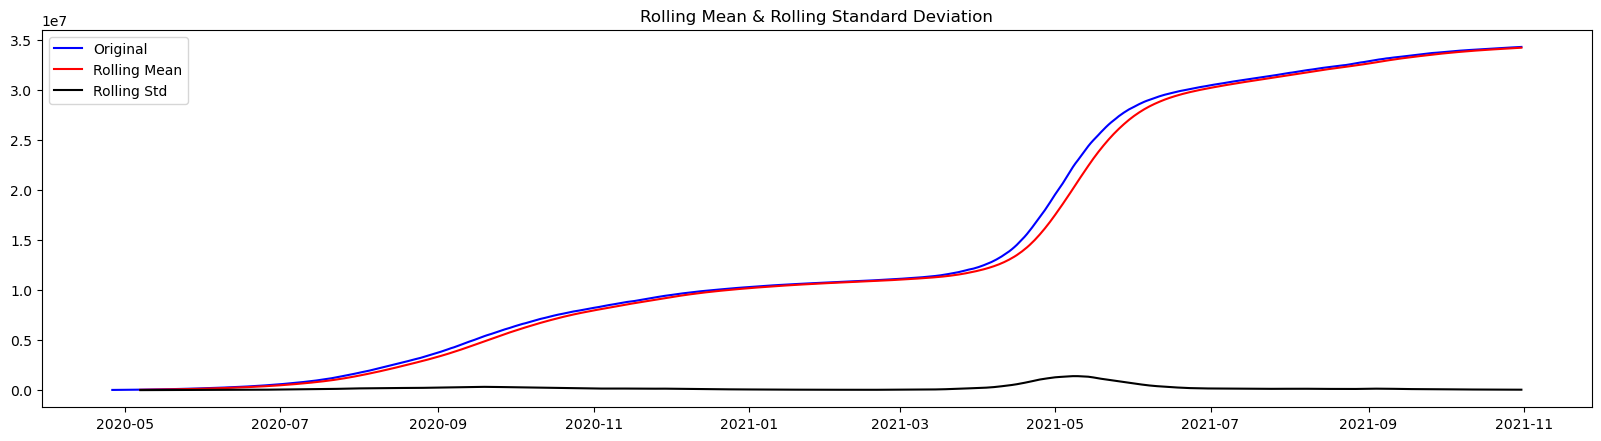

In [11]:
fig = plt.figure(figsize=(20,5),dpi=100)
rolling_mean = data3['Confirmed'].rolling(window = 12).mean()
rolling_std = data3['Confirmed'].rolling(window = 12).std()

plt.plot(data3['Date'],data3['Confirmed'], color = 'blue', label = 'Original')
plt.plot(data3['Date'],rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(data3['Date'],rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Augmented Dickey-Fuller (ADF) test for stationarity 

In [12]:
result = adfuller(data3['Confirmed'],autolag = 'AIC')
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.042816189104699684
p-value: 0.9548447054789171
Critical Values:
	1%: -3.442563336759378
	5%: -2.866927190004947
	10%: -2.5696391843672695


From the tests above we see the data is non stationary

Model 1 FB Prophet

In [13]:
data4 = data3 #Taking a copy of the dataset to make changes
data4.columns = ['ds','y']
data4

,ds,y
0,2020-04-26,27890
1,2020-04-27,29458
2,2020-04-28,31360
3,2020-04-29,33065
4,2020-04-30,34867
...,...,...
549,2021-10-27,34231243
550,2021-10-28,34245550
551,2021-10-29,34259765
552,2021-10-30,34272705


In [14]:
from fbprophet import Prophet

Model fitting

In [15]:
model = Prophet()
fittedmodel = model.fit(data4)
future_dates = model.make_future_dataframe(periods = 90)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\mrsur\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Forecasting for 3 months in the future

In [16]:
future_dates = model.make_future_dataframe(periods = 90)
prediction = model.predict(future_dates)
prediction.tail()

C:\Users\mrsur\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\mrsur\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
639,2022-01-25,3.741556e+07,3.257550e+07,4.271104e+07,3.254726e+07,4.270808e+07,-4500.009151,-4500.009151,-4500.009151,-4500.009151,-4500.009151,-4500.009151,0.0,0.0,0.0,3.741106e+07
640,2022-01-26,3.744772e+07,3.250556e+07,4.280292e+07,3.247307e+07,4.281520e+07,-1476.051093,-1476.051093,-1476.051093,-1476.051093,-1476.051093,-1476.051093,0.0,0.0,0.0,3.744624e+07
641,2022-01-27,3.747988e+07,3.242413e+07,4.294073e+07,3.240971e+07,4.295225e+07,796.005451,796.005451,796.005451,796.005451,796.005451,796.005451,0.0,0.0,0.0,3.748068e+07
642,2022-01-28,3.751204e+07,3.229898e+07,4.306140e+07,3.230701e+07,4.307983e+07,2374.351273,2374.351273,2374.351273,2374.351273,2374.351273,2374.351273,0.0,0.0,0.0,3.751442e+07
643,2022-01-29,3.754420e+07,3.222898e+07,4.314070e+07,3.222091e+07,4.318837e+07,3387.706076,3387.706076,3387.706076,3387.706076,3387.706076,3387.706076,0.0,0.0,0.0,3.754759e+07


Plotting the data along with forecast

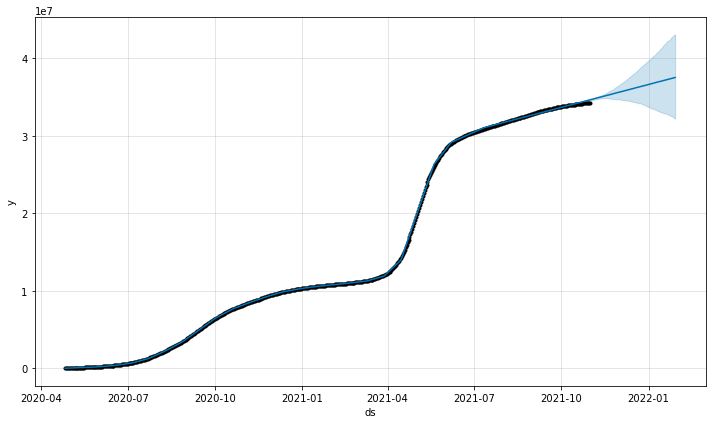

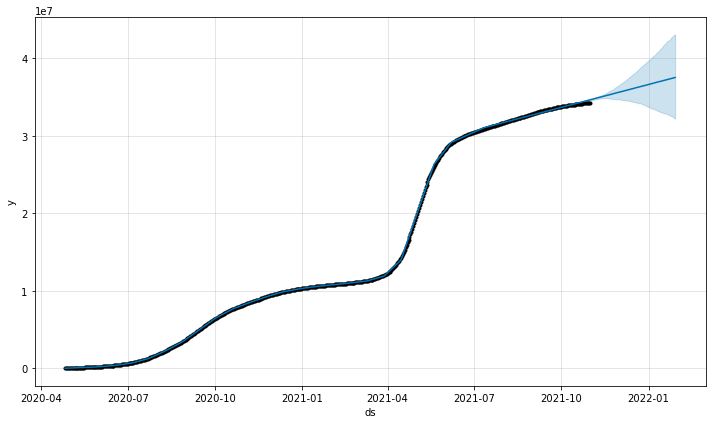

In [17]:
model.plot(prediction)

Dataset with future predictions

In [18]:
prediction[['ds','yhat']]

,ds,yhat
0,2020-04-26,4.626656e+03
1,2020-04-27,4.248043e+03
2,2020-04-28,7.688086e+03
3,2020-04-29,1.568521e+04
4,2020-04-30,2.293043e+04
...,...,...
639,2022-01-25,3.741106e+07
640,2022-01-26,3.744624e+07
641,2022-01-27,3.748068e+07
642,2022-01-28,3.751442e+07


Evaluating the model

In [19]:
propheteval = prediction[:554] #Initial dates
propheteval = propheteval['yhat'] #Retreiving only yhat (predicted value)
propheteval = pd.DataFrame(propheteval)
propheteval['actual'] = data2['Confirmed'] #Appending actual values
propheteval

,yhat,actual
0,4.626656e+03,27890
1,4.248043e+03,29458
2,7.688086e+03,31360
3,1.568521e+04,33065
4,2.293043e+04,34867
...,...,...
549,3.451968e+07,34231243
550,3.455411e+07,34245550
551,3.458785e+07,34259765
552,3.462102e+07,34272705


Evaluation metrics

In [20]:
print("Mean square error (MSE): " , np.mean((propheteval['actual'] - propheteval['yhat']) ** 2))
print("R2-score:" , r2_score(propheteval['actual'],propheteval['yhat'] ) )

Mean square error (MSE):  6918843068.859493
R2-score: 0.9999529591489023


Model 2 Holt Winters model

In [21]:
data3.columns=['Date','Confirmed']
data3.index = data3['Date']
data3.drop(columns='Date',inplace = True)
data3.parse_dates = True
data3

<ipython-input-21-e04831e7cfee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop(columns='Date',inplace = True)


,Confirmed
Date,
2020-04-26,27890
2020-04-27,29458
2020-04-28,31360
2020-04-29,33065
2020-04-30,34867
...,...
2021-10-27,34231243
2021-10-28,34245550
2021-10-29,34259765


<AxesSubplot:title={'center':'Confirmed cases'}, xlabel='Date'>

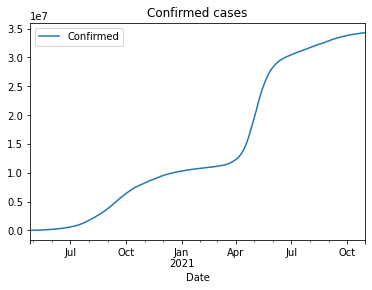

In [22]:
data3.plot(title='Confirmed cases')

Checking seasonality of the data

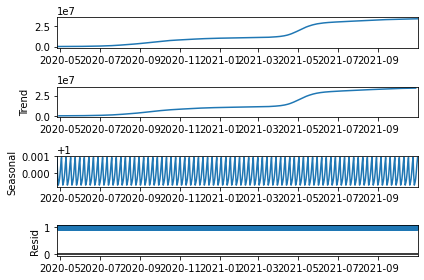

In [23]:
data3.dtypes
decompose_result = seasonal_decompose(data3,model='multiplicative',period=7)
decompose_result.plot();

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Holt-Winters Double Exponential Smoothing

HW2_ADD - Holt-Winters Double Exponential Smoothing (Additive)

C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-25-d383a0e45083>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['HW2_ADD'] = ExponentialSmoothing(data3['Confirmed'],trend='add',seasonal = 'add', seasonal_period

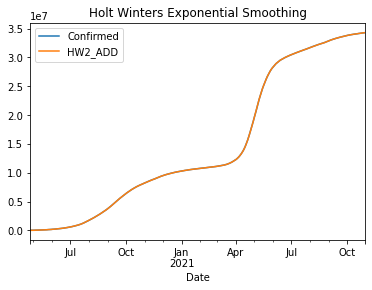

In [25]:
data3['HW2_ADD'] = ExponentialSmoothing(data3['Confirmed'],trend='add',seasonal = 'add', seasonal_periods = 7).fit().fittedvalues
data3[['Confirmed','HW2_ADD']].plot(title='Holt Winters Exponential Smoothing');

Good match for these parameters and algorithm

In [26]:
data3['HW2_ADD'] #Predicted values

Date
2020-04-26    3.068198e+04
2020-04-27    2.979148e+04
2020-04-28    3.128716e+04
2020-04-29    3.304284e+04
2020-04-30    3.486729e+04
                  ...     
2021-10-27    3.424180e+07
2021-10-28    3.424820e+07
2021-10-29    3.425676e+07
2021-10-30    3.426768e+07
2021-10-31    3.427870e+07
Name: HW2_ADD, Length: 554, dtype: float64

Fitting the model, forecasting for 3 months in the future and plotting

C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\mrsur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Text(0.5, 1.0, 'COVID 19 Cases Prediction using Holt Winters')

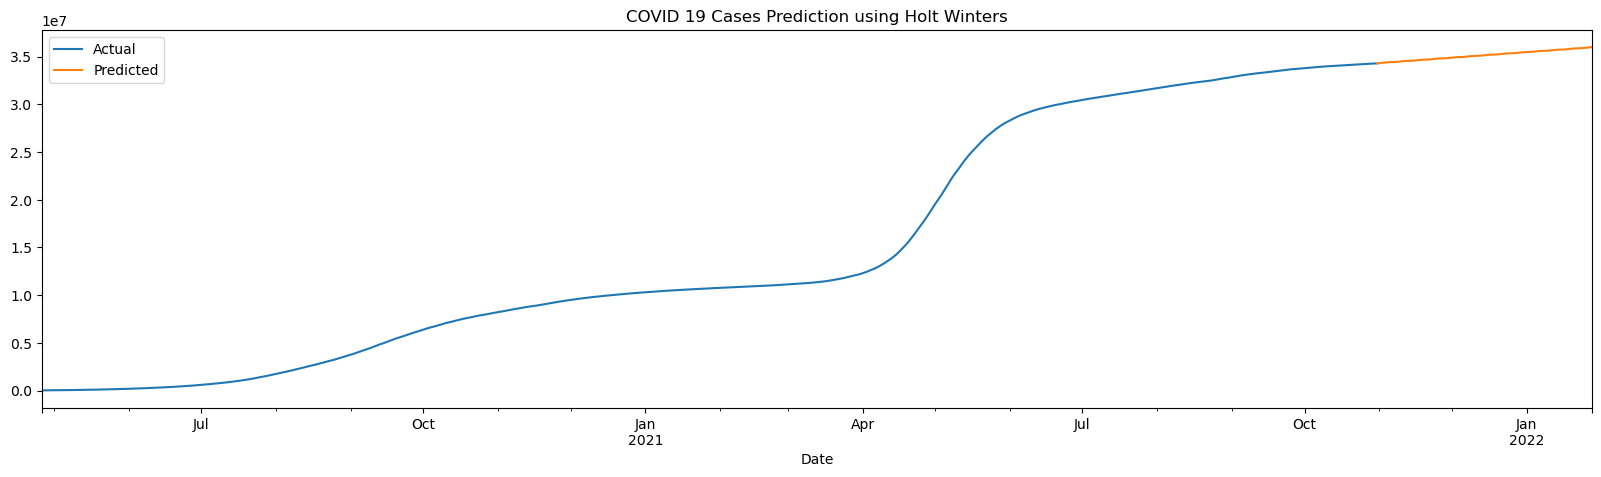

In [27]:
fig = plt.figure(figsize=(20,5),dpi=100)
fitted_model = ExponentialSmoothing(data3['Confirmed'],trend='add',seasonal = 'add',seasonal_periods = 7).fit()
test_predictions = fitted_model.forecast(90)
test_predictions.index = pd.date_range(start="2021-10-31",periods = 90)
test_predictions

data3['Confirmed'].plot(legend=True,label='Actual')
test_predictions.plot(legend=True,label='Predicted')
plt.title('COVID 19 Cases Prediction using Holt Winters')

Dataset with future predictions

In [28]:
data = test_predictions.to_frame()
data

,0
2021-10-31,3.428824e+07
2021-11-01,3.430392e+07
2021-11-02,3.433199e+07
2021-11-03,3.436010e+07
2021-11-04,3.438514e+07
...,...
2022-01-24,3.587950e+07
2022-01-25,3.590757e+07
2022-01-26,3.593568e+07
2022-01-27,3.596072e+07


Evaluating the model

In [29]:
holteval = data3['HW2_ADD'] #Predicted values
holteval = pd.DataFrame(holteval)
holteval['actual'] = data3['Confirmed'] #Actual values
holteval

,HW2_ADD,actual
Date,,
2020-04-26,3.068198e+04,27890
2020-04-27,2.979148e+04,29458
2020-04-28,3.128716e+04,31360
2020-04-29,3.304284e+04,33065
2020-04-30,3.486729e+04,34867
...,...,...
2021-10-27,3.424180e+07,34231243
2021-10-28,3.424820e+07,34245550
2021-10-29,3.425676e+07,34259765


Evaluation metrics

In [30]:
print("Mean square error (MSE): " , np.mean((holteval['actual'] - holteval['HW2_ADD']) ** 2))
print("R2-score:" , r2_score(holteval['actual'],holteval['HW2_ADD'] ) )

Mean square error (MSE):  54611075.72333061
R2-score: 0.9999996287021607


Conclusions

From the above two models we can see

Holt Winters model has a higher R^2 score hence indicating a better fit to the data

Holt winters also has a lower mean squared error (MSE)

Hence Holt Winters model is more accurate for predictions and forecasts